In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pyplot as plt

/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


In [2]:
#Read the data into train and test variables
X_train_full = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
X_test_full = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')
X_train = X_train_full.copy()
X_test=X_test_full.copy()
X_train.info()
target_col = 'outcome'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

In [3]:
#deifine some functions to assure test and training data are handled consistently

def fill_na_values(col_name,fill_value = 0,train_data=X_train,test_data=X_test):
    train_data[col_name].fillna(fill_value,inplace=True)
    test_data[col_name].fillna(fill_value,inplace=True)
    
def drop_column(col_name,train_data=X_train,test_data=X_test):
    train_data.drop(col_name,axis = 1,inplace=True)
    test_data.drop(col_name,axis=1,inplace=True)
    
def swap_cat_to_num(col_name,swap_dict,train_data=X_train,test_data=X_test):
    print('Replacing .....')
    train_data[col_name] = train_data[col_name].apply(lambda x: swap_dict.get(x))
    test_data[col_name] = test_data[col_name].apply(lambda x: swap_dict.get(x))
    
def make_result_pie_plot(col_name,target_col = target_col,train_data=X_train): 
    unique_values = train_data[col_name].unique()
    fig = plt.figure(figsize=(20,unique_values.shape[0]))
    i=1
    for value in unique_values:
        plt_rows = math.ceil(unique_values.shape[0]/6)
        fig.add_subplot(plt_rows, 6, i)
        plt.title('Title : {}'.format(value))
        train_data[target_col][train_data[col_name] == value].value_counts().plot(kind='pie')
        i += 1
        
def explore_column(col_name,train_data=X_train, target_col = target_col):
    print('Pie plots for ',col_name,'...')
    make_result_pie_plot(col_name)
    return train_data[col_name].head(), train_data[col_name].unique()

# def ohe_column(col_name,train_data=X_train,test_data=X_test,valid_data=X_valid):
#     #one hot encode training data and concat to df
#     ohe_train = pd.get_dummies(train_df[column_name],prefix=col_name)
#     train_df = pd.concat([train_df,ohe_train],axis=1)
    
#     #one hot encode test data and concat to df
#     if test_data:
#         ohe_test = pd.get_dummies(test_df[column_name],prefix=col_name)
#         test_df = pd.concat([test_df,ohe_test],axis=1)
#         if valid_data:
#             ohe_valid = pd.get_dummies(valid_df[column_name],prefix=col_name)
#             valid_df = pd.concat([valid_df,ohe_test],axis=1)
#             return train_df,test_df,valid_df
#         return train_df,test_df
#     return train_df
    


In [4]:
X_train.describe()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,0.0000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,308.5000,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,617.0000,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,925.5000,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,1234.0000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [5]:
X_train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [6]:
X_train.isnull().sum()

id                         0
surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64

In [7]:
drop_column("id")
drop_column('hospital_number')

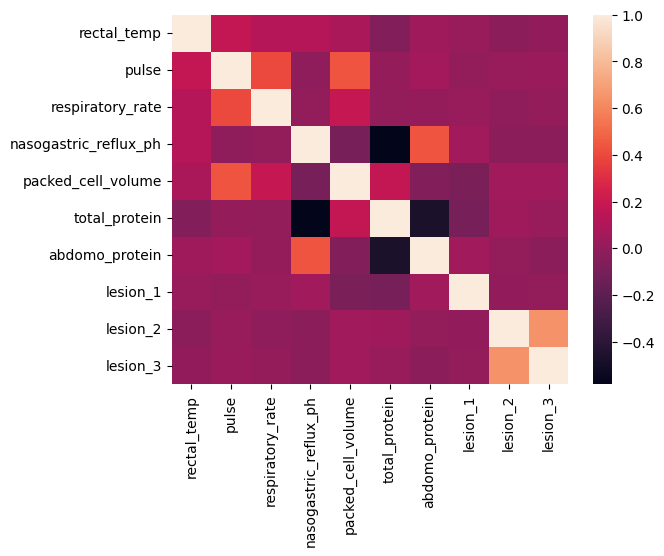

In [8]:

num_cols=[col for col in X_train.columns if X_train[col].dtype in ['float64','int64']]
corr_map = sns.heatmap(X_train[num_cols].corr())
plt.show()

Pie plots for  abdomen ...


(0    distend_small
 1    distend_small
 2    distend_large
 3    distend_small
 4           normal
 Name: abdomen, dtype: object,
 array(['distend_small', 'distend_large', 'normal', 'firm', nan, 'other'],
       dtype=object))

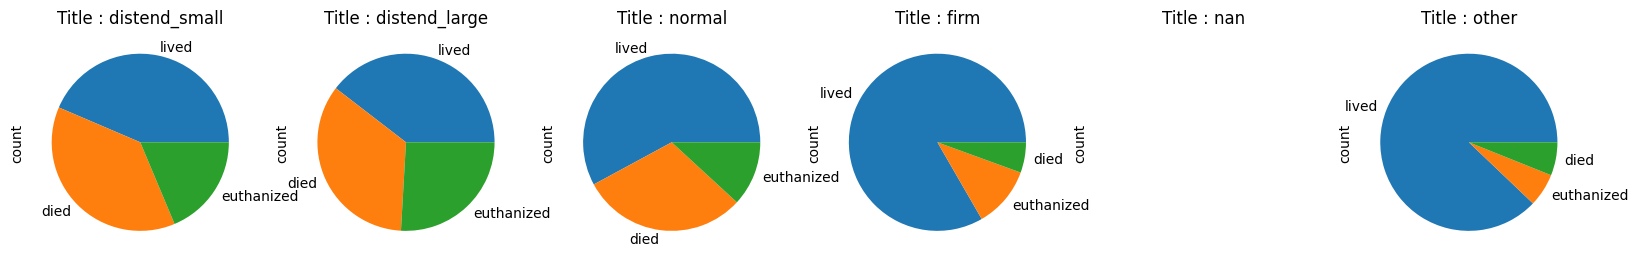

In [9]:
explore_column('abdomen')

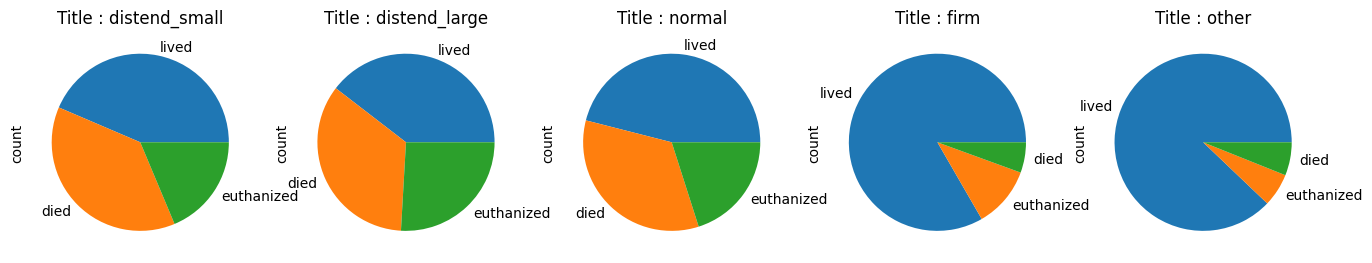

In [10]:
#Assume rectal_exam_feces was NaN if symptoms didnt warrant a check - >> replace NaN with Normal
X_train['abdomen'].fillna('normal',inplace=True)
fill_na_values('abdomen', fill_value = 'normal')
make_result_pie_plot('abdomen')

Pie plots for  pain ...


(0       depressed
 1       mild_pain
 2    extreme_pain
 3       mild_pain
 4           alert
 Name: pain, dtype: object,
 array(['depressed', 'mild_pain', 'extreme_pain', 'alert', 'severe_pain',
        nan, 'slight'], dtype=object))

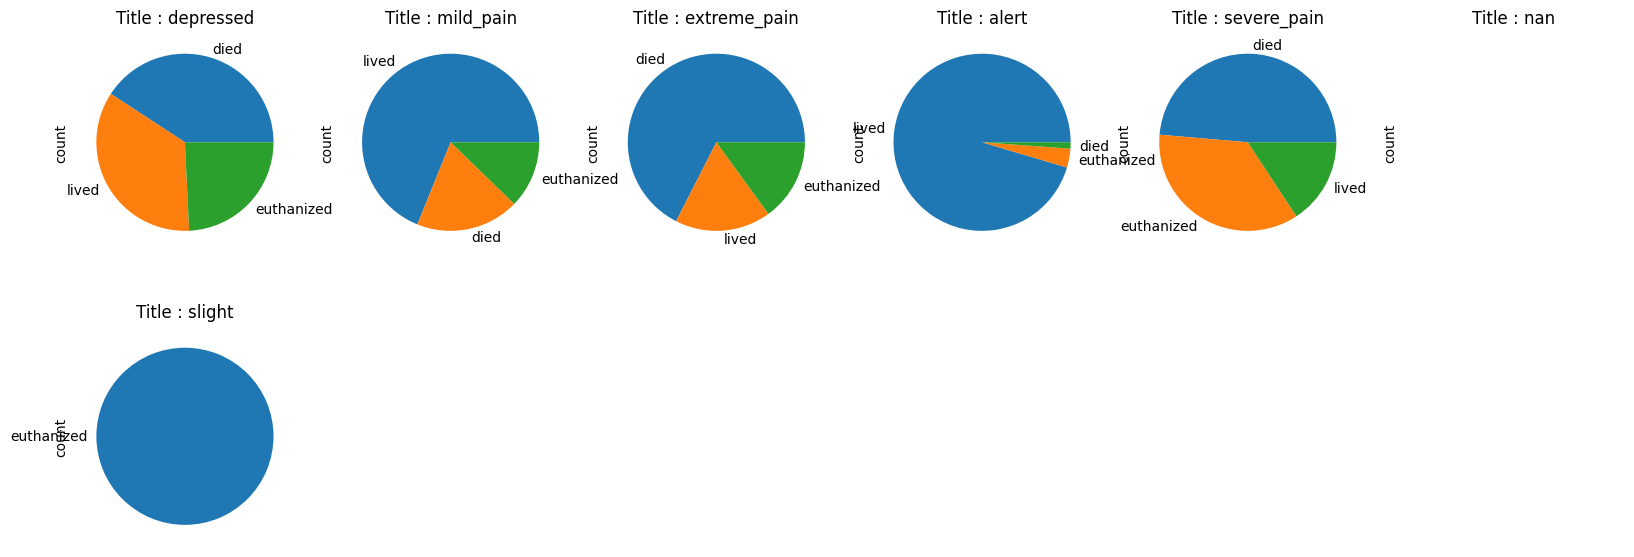

In [11]:
explore_column('pain')

In [12]:
X_train.loc[X_train['pain'] == 'slight']

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
1187,yes,adult,37.5,72.0,60.0,NaN,normal,bright_red,less_3_sec,slight,...,48.0,8.0,serosanguious,2.3,yes,2207,0,0,no,euthanized


In [13]:
swap_dict={
    'alert':0,
    'mild_pain':1,
    'slight':1,
    'depressed':2,
    'severe_pain':3,
    'extreme_pain':4
}

swap_cat_to_num('pain',swap_dict)

Replacing .....


In [14]:
#Assume rectal_exam_feces was NaN if symptoms didnt warrant a check - >> replace NaN with Normal
fill_na_values('rectal_exam_feces',fill_value = 'normal',)

Pie plots for  rectal_exam_feces ...


(0    decreased
 1       absent
 2       normal
 3    decreased
 4       normal
 Name: rectal_exam_feces, dtype: object,
 array(['decreased', 'absent', 'normal', 'increased', 'serosanguious'],
       dtype=object))

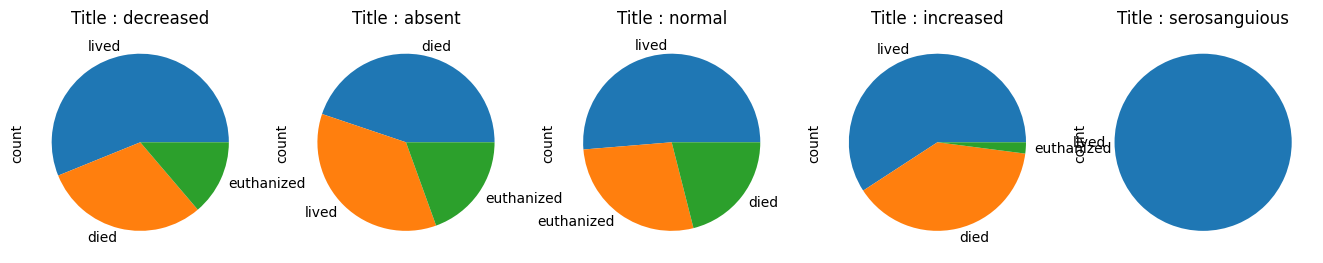

In [15]:
explore_column('rectal_exam_feces')

In [16]:
X_train.loc[X_train['rectal_exam_feces'] == 'serosanguious']
X_test.loc[X_train['rectal_exam_feces'] == 'serosanguious']
swap_dict = {
    'increased':0,
    'decreased':0,
    'serosanguious':0,
    'normal':1,
    'absent':2
}

swap_cat_to_num('rectal_exam_feces',swap_dict,)

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
255,yes,adult,35.4,52.0,24.0,cool,reduced,pale_cyanotic,more_3_sec,2.0,...,57.0,69.0,serosanguious,2.0,yes,2124,0,0,no,lived


,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
255,yes,adult,37.1,75.0,36.0,NaN,NaN,pale_cyanotic,more_3_sec,3.0,...,normal,48.0,7.4,serosanguious,3.2,yes,400,0,0,no


Replacing .....


Pie plots for  abdominal_distention ...


(0      slight
 1    moderate
 2    moderate
 3    moderate
 4        none
 Name: abdominal_distention, dtype: object,
 array(['slight', 'moderate', 'none', 'severe', nan], dtype=object))

Replacing .....
Pie plots for  nasogastric_tube ...


(0    slight
 1      none
 2    slight
 3    slight
 4    slight
 Name: nasogastric_tube, dtype: object,
 array(['slight', 'none', 'significant', nan], dtype=object))

Replacing .....
Pie plots for  nasogastric_reflux ...


(0    less_1_liter
 1    more_1_liter
 2            none
 3    more_1_liter
 4    less_1_liter
 Name: nasogastric_reflux, dtype: object,
 array(['less_1_liter', 'more_1_liter', 'none', nan, 'slight'],
       dtype=object))

Replacing .....
Pie plots for  nasogastric_reflux_ph ...


(0    6.5
 1    2.0
 2    3.5
 3    2.0
 4    7.0
 Name: nasogastric_reflux_ph, dtype: float64,
 array([6.5, 2. , 3.5, 7. , 5. , 4.5, 4.4, 5.3, 6. , 3. , 7.5, 5.5, 5.7,
        1. , 4. , 5.4, 7.2, 6.2, 5.2, 4.3, 1.5, 6.8, 4.2, 3.4, 2.6, 6.6]))

,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph
34,2.0,1.0,NaN,4.5
55,2.0,1.0,NaN,7.5
93,1.0,2.0,NaN,7.0
99,0.0,0.0,NaN,3.0
184,1.0,2.0,NaN,7.0
278,1.0,NaN,NaN,5.0
382,1.0,1.0,NaN,5.0
520,1.0,1.0,NaN,7.0
615,1.0,2.0,NaN,2.0
695,2.0,NaN,NaN,4.3


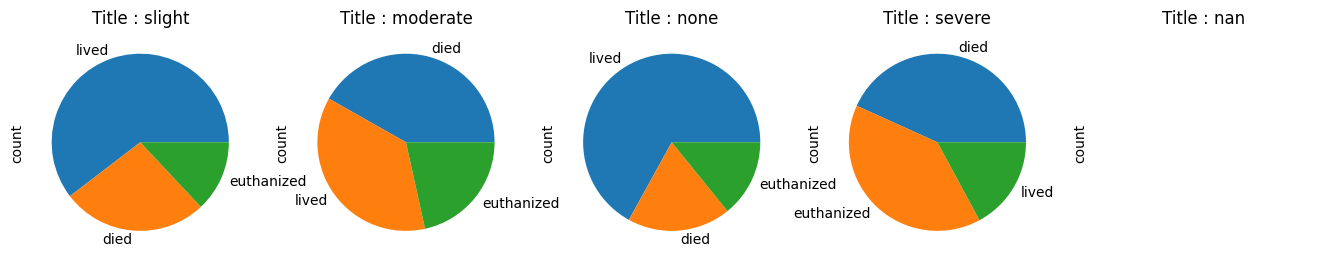

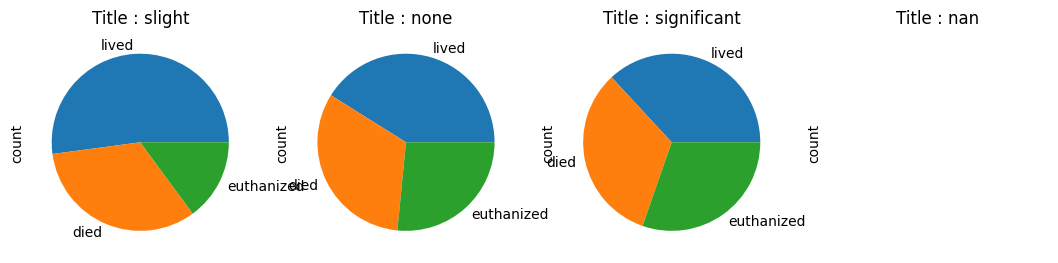

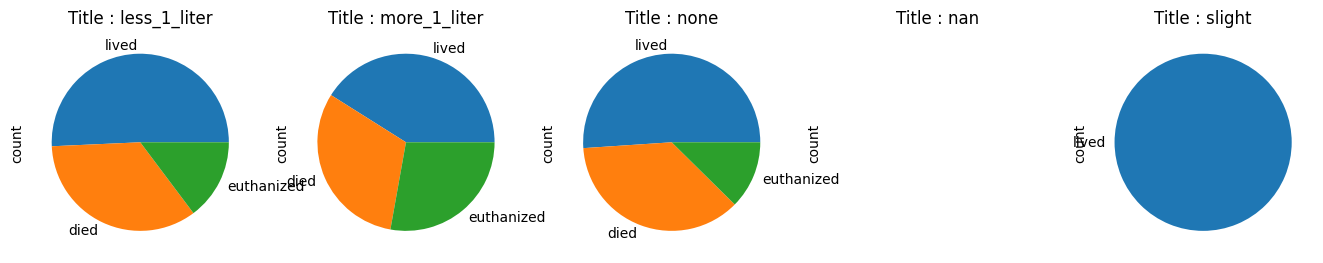

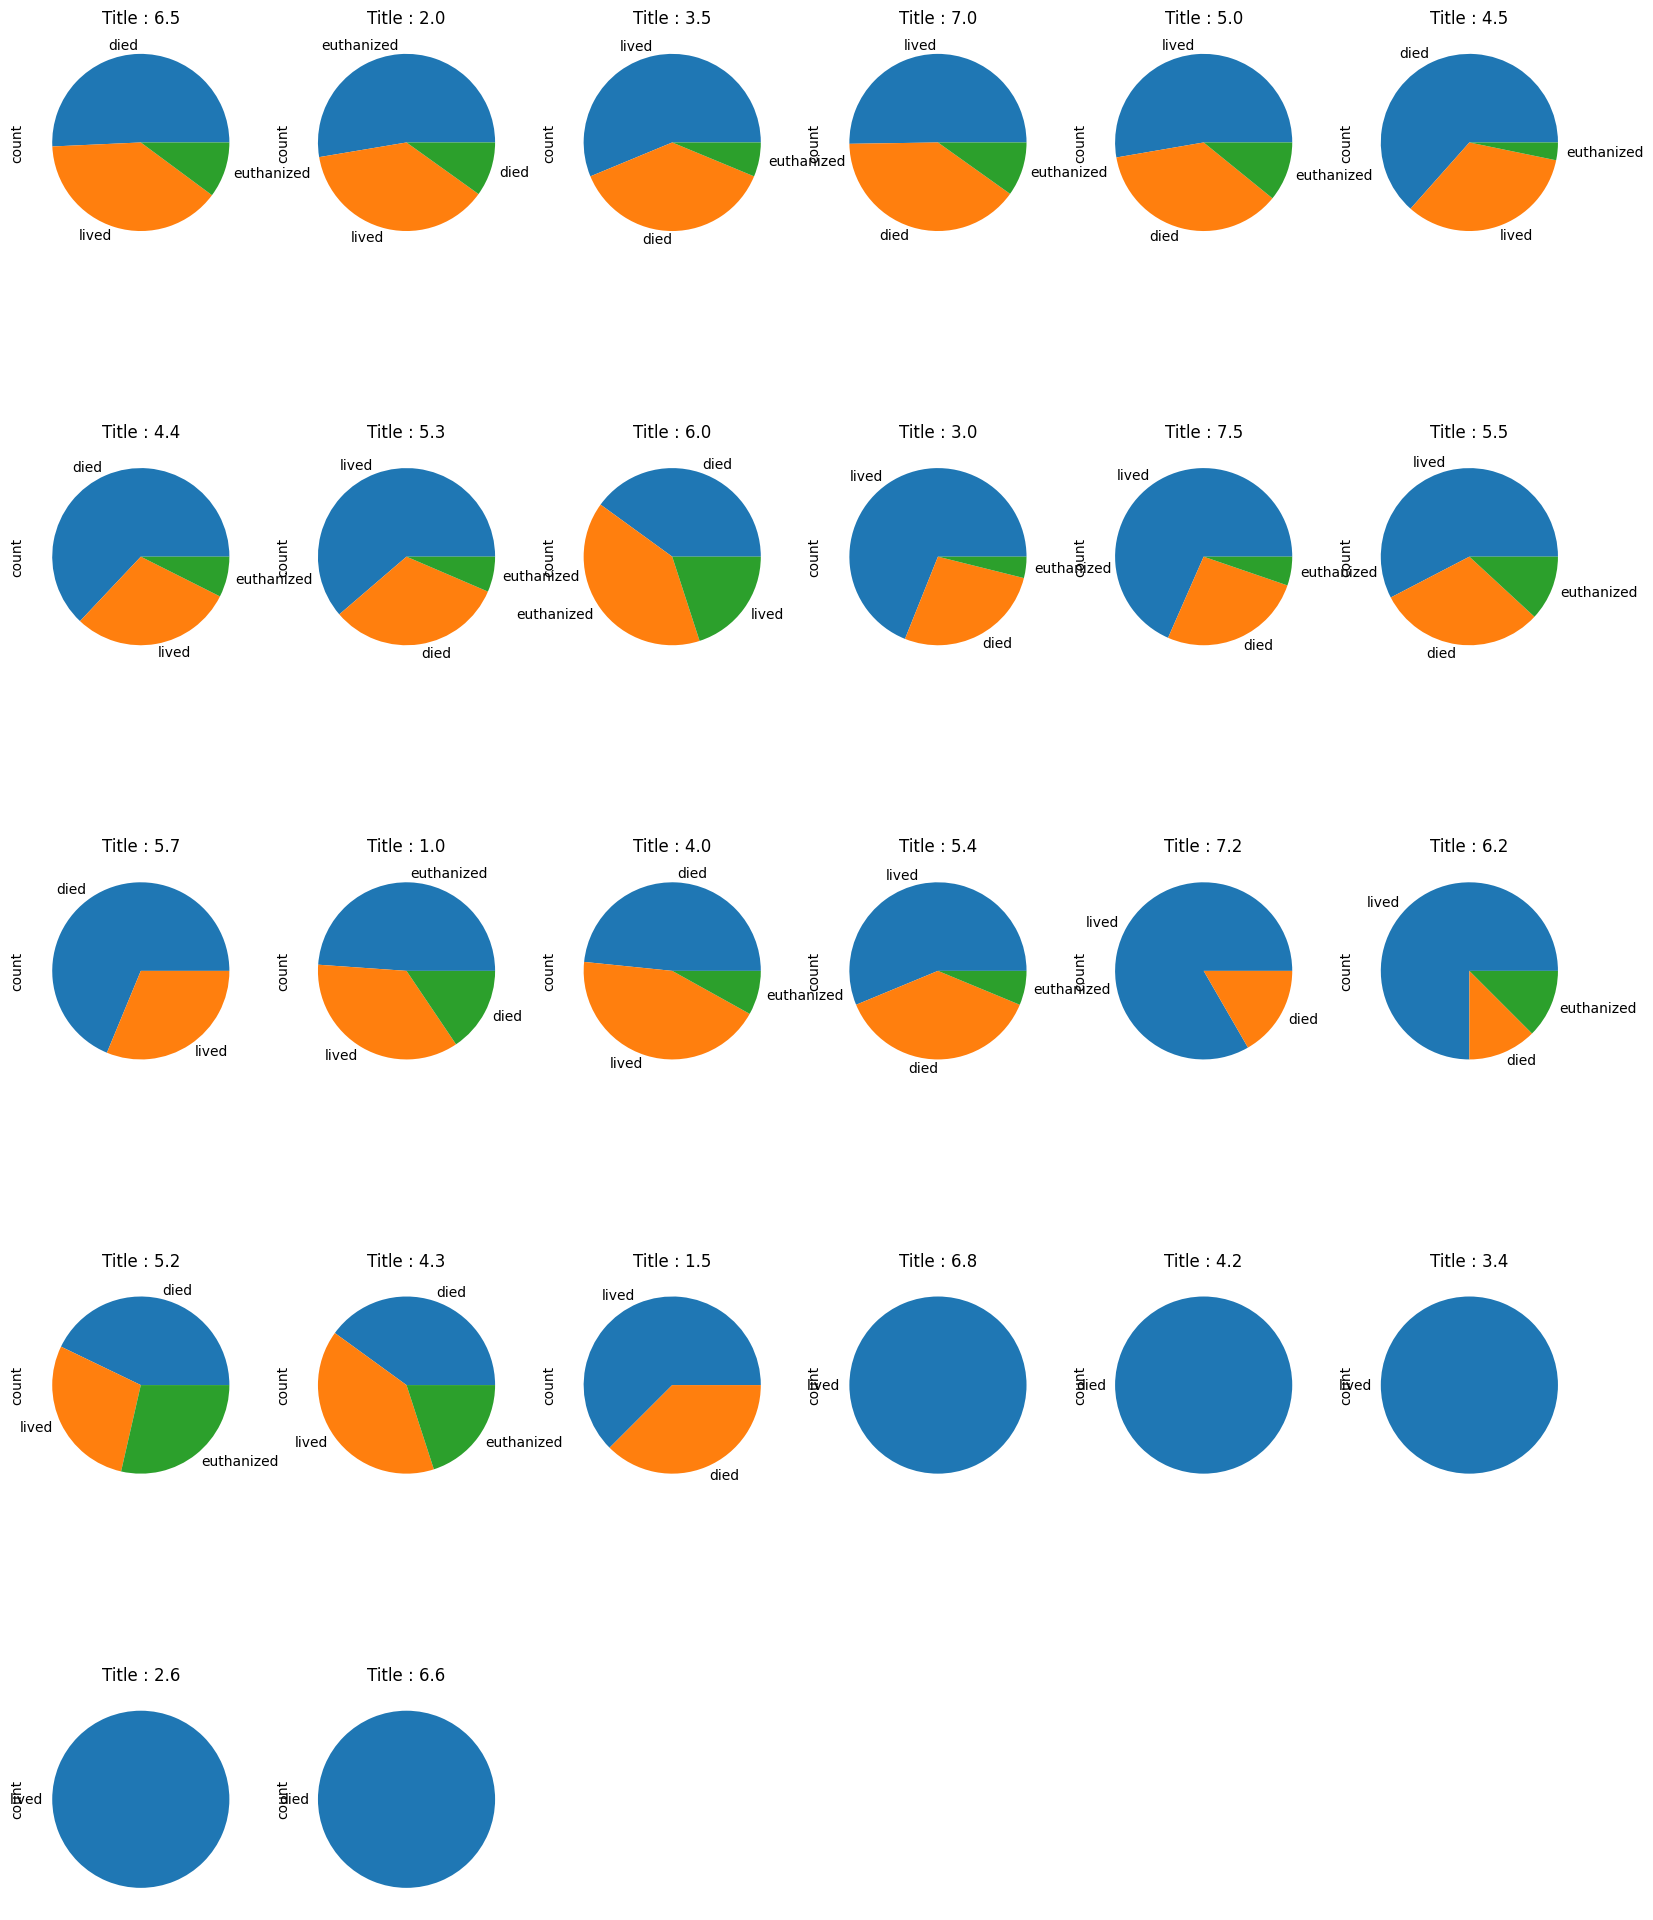

In [17]:
explore_column('abdominal_distention')

swap = {'none':0,
              'slight':1,
              'moderate':2,
              'severe':3}
swap_cat_to_num('abdominal_distention',swap)

explore_column('nasogastric_tube')

swap = {'none':0,
              'slight':1,
              'significant':2,
              }
swap_cat_to_num('nasogastric_tube',swap)

explore_column('nasogastric_reflux')

swap = {'none':0,
              'slight':1,
              'less_1_liter':2,
              'more_1_liter':3}
swap_cat_to_num('nasogastric_reflux',swap)

explore_column('nasogastric_reflux_ph')

X_train[['abdominal_distention','nasogastric_tube','nasogastric_reflux','nasogastric_reflux_ph']].loc[X_train['nasogastric_reflux'].isnull()].head(20)

In [18]:
#split off target data

y=X_train['outcome']
X_train.drop('outcome',axis=1,inplace=True)


In [19]:
#create categorical and numerical column lists
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['float64','int64']]
cat_cols
num_cols
            

['surgery',
 'age',
 'temp_of_extremities',
 'peripheral_pulse',
 'mucous_membrane',
 'capillary_refill_time',
 'peristalsis',
 'abdomen',
 'abdomo_appearance',
 'surgical_lesion',
 'cp_data']

['rectal_temp',
 'pulse',
 'respiratory_rate',
 'pain',
 'abdominal_distention',
 'nasogastric_tube',
 'nasogastric_reflux',
 'nasogastric_reflux_ph',
 'rectal_exam_feces',
 'packed_cell_volume',
 'total_protein',
 'abdomo_protein',
 'lesion_1',
 'lesion_2',
 'lesion_3']

In [20]:


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

#map target values to numerical values
replacement = {
    'lived': 0,
    'died': 1,
    'euthanized': 2
}

y = y.apply(lambda x: replacement.get(x))

# #Create transformers
# cat_transformer = make_pipeline(
#     SimpleImputer(strategy="most_frequent"),
#     #IterativeImputer(initial_strategy="constant"),
#     #OneHotEncoder(handle_unknown='ignore'),
# )

# num_transformer = make_pipeline(
#     #SimpleImputer(strategy='median'),
#     IterativeImputer(initial_strategy="median"),
#     StandardScaler(),
# )

# preprocessor = make_column_transformer(
#     (cat_transformer,cat_cols),
#     (num_transformer,num_cols),
# )





X_train,X_valid,y_train,y_valid = train_test_split(X_train,y,stratify = y,random_state=0)

my_cat_imputer = SimpleImputer(strategy='most_frequent',)

#impute categorical training data
X_train_cat= pd.DataFrame(my_cat_imputer.fit_transform(X_train[cat_cols],y_train))
X_train_cat.columns=X_train[cat_cols].columns
#impute categorical validation data
X_valid_cat= pd.DataFrame(my_cat_imputer.transform(X_valid[cat_cols]))
X_valid_cat.columns=X_valid[cat_cols].columns
#impute categorical test data
X_test_cat= pd.DataFrame(my_cat_imputer.transform(X_test[cat_cols]))
X_test_cat.columns=X_test[cat_cols].columns


#one hot encode each cat column with get_dummies so that columns are named
for col in cat_cols:
    #training data
    ohe_train = pd.get_dummies(X_train_cat[col],prefix=col)
    X_train_cat = pd.concat([X_train_cat,ohe_train],axis=1)
    X_train_cat.drop(col,axis=1,inplace=True)
    #validation data
    ohe_valid = pd.get_dummies(X_valid_cat[col],prefix=col)
    X_valid_cat = pd.concat([X_valid_cat,ohe_valid],axis=1)
    X_valid_cat.drop(col,axis=1,inplace=True)
    #test data
    ohe_test = pd.get_dummies(X_test_cat[col],prefix=col)
    X_test_cat = pd.concat([X_test_cat,ohe_test],axis=1)
    X_test_cat.drop(col,axis=1,inplace=True)


my_num_imputer = IterativeImputer(initial_strategy='median',)
#impute numerical training data
X_train_num = pd.DataFrame(my_num_imputer.fit_transform(X_train[num_cols],y_train))
X_train_num.columns=X_train[num_cols].columns
#impute numerical validation data
X_valid_num = pd.DataFrame(my_num_imputer.transform(X_valid[num_cols]))
X_valid_num.columns=X_valid[num_cols].columns
#impute numerical test data
X_test_num = pd.DataFrame(my_num_imputer.transform(X_test[num_cols]))
X_test_num.columns=X_test[num_cols].columns


#put numerical and categorical columns back together
#training
X_train_processed = pd.concat([X_train_cat,X_train_num],axis=1)
X_train_processed.info()
#validation
X_valid_processed = pd.concat([X_valid_cat,X_valid_num],axis=1)
#test
X_test_processed = pd.concat([X_test_cat,X_test_num],axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 52 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   surgery_no                        926 non-null    bool   
 1   surgery_yes                       926 non-null    bool   
 2   age_adult                         926 non-null    bool   
 3   age_young                         926 non-null    bool   
 4   temp_of_extremities_cold          926 non-null    bool   
 5   temp_of_extremities_cool          926 non-null    bool   
 6   temp_of_extremities_normal        926 non-null    bool   
 7   temp_of_extremities_warm          926 non-null    bool   
 8   peripheral_pulse_absent           926 non-null    bool   
 9   peripheral_pulse_increased        926 non-null    bool   
 10  peripheral_pulse_normal           926 non-null    bool   
 11  peripheral_pulse_reduced          926 non-null    bool   
 12  mucous_m

In [21]:
#Lets look at the mutual information...

from sklearn.feature_selection import mutual_info_classif as MIC
#numerical_cols = numerical_cols = [cname for cname in X_train_.columns if X_train_[cname].dtype in ['int64', 'float64']]
mi_score1 = MIC(X_train_processed,y_train,random_state=0)
mi_scoreCl = pd.Series(mi_score1, name="MI Cl Scores",index=X_train_processed.columns)
mi_scoreCl =mi_scoreCl.sort_values(ascending=False)
print(mi_scoreCl)

lesion_1                            0.199240
pain                                0.155385
packed_cell_volume                  0.155277
pulse                               0.149858
abdomo_protein                      0.142604
total_protein                       0.124988
nasogastric_reflux_ph               0.100749
abdomo_appearance_clear             0.070125
abdomo_appearance_serosanguious     0.064072
temp_of_extremities_normal          0.063317
peristalsis_absent                  0.059621
capillary_refill_time_less_3_sec    0.057386
abdominal_distention                0.056921
surgical_lesion_yes                 0.056317
surgical_lesion_no                  0.053546
cp_data_yes                         0.053053
mucous_membrane_pale_cyanotic       0.048939
peripheral_pulse_reduced            0.046628
capillary_refill_time_more_3_sec    0.044664
nasogastric_tube                    0.044656
abdomen_distend_large               0.042812
nasogastric_reflux                  0.041104
age_young 

In [22]:
for col in mi_scoreCl[mi_scoreCl<0.037724].index:
    X_train_processed.drop(col,axis=1,inplace=True)
    if col in X_valid_processed.columns:
        X_valid_processed.drop(col,axis=1,inplace=True)
    if col in X_test_processed.columns:
        X_test_processed.drop(col,axis=1,inplace=True)
    
X_valid_processed.drop('capillary_refill_time_3',axis=1,inplace=True)
X_test_processed.drop('capillary_refill_time_3',axis=1,inplace=True)

#X_train_processed.info()
    

<Axes: >

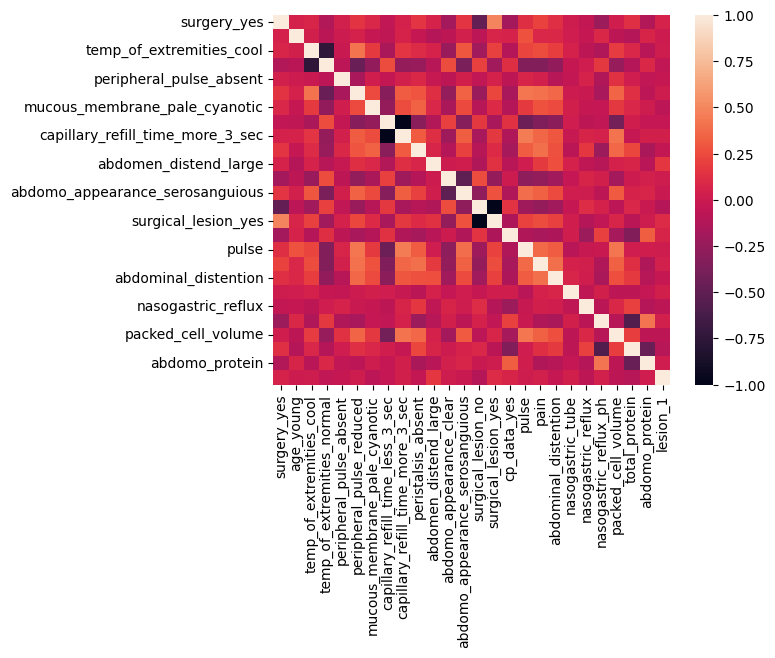

In [23]:
#X_train_df = pd.DataFrame(X_train)
#X_train_df.info()
sns.heatmap(X_train_processed.corr())
plt.show()

In [24]:
#Try XGBoost model

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer

# param_grid = {
#     "max_depth": [3, 4, 5, 7],
#     "learning_rate": [0.1, 0.01, 0.05],
#     "gamma": [0, 0.25, 1],
#     "reg_lambda": [0, 1, 10],
#     #"scale_pos_weight": [1, 3, 5],
#     "subsample": [0.8],
#     "colsample_bytree": [0.5],
# }

# model = xgb.XGBClassifier()
# #my_scorer=make_scorer(score_func=f1_score(y_valid,preds,average='macro'),greater_is_better=True)
# grid_cv = GridSearchCV(model, param_grid, n_jobs=-1, cv=3, scoring='f1_micro')
# grid_cv.fit(X_train, y_train)

# preds = grid_cv.predict(X_valid)
# #grid_cv.score(X_valid,y_valid)
# accuracy_score(y_valid, preds)

In [25]:
#Try RandomForest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0,max_depth=10,n_estimators=1000)
model.fit(X_train_processed,y_train)
preds = model.predict(X_valid_processed)

accuracy_score(y_valid, preds)

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=0)

0.6957928802588996

In [26]:
# #Try svm
# from sklearn import svm

# model = svm.SVC(random_state=0)
# model.fit(X_train,y_train)
# preds = model.predict(X_valid)

# accuracy_score(y_valid, preds)

In [27]:

test_ids = X_test_full.id
preds = model.predict(X_test_processed)

#map target values to numerical values
replacement = {
    0:'lived',
    1:'died',
    2:'euthanized'
}

preds = pd.DataFrame(preds, columns = ['outcome'])
preds['outcome'] = preds['outcome'].apply(lambda x: replacement.get(x))
preds['id'] = test_ids

# Save test predictions to file

preds
preds.to_csv('submission.csv', index=False)


,outcome,id
0,lived,1235
1,died,1236
2,lived,1237
3,euthanized,1238
4,lived,1239
...,...,...
819,died,2054
820,euthanized,2055
821,died,2056
822,lived,2057
